Using device: cuda


100%|██████████| 169M/169M [00:03<00:00, 49.0MB/s]



=== Training ViT-Light ===
[ViT-Light] Epoch [1/10], Step [100/782], Loss: 4.4209
[ViT-Light] Epoch [1/10], Step [200/782], Loss: 4.4682
[ViT-Light] Epoch [1/10], Step [300/782], Loss: 4.0777
[ViT-Light] Epoch [1/10], Step [400/782], Loss: 3.7966
[ViT-Light] Epoch [1/10], Step [500/782], Loss: 4.1112
[ViT-Light] Epoch [1/10], Step [600/782], Loss: 4.1632
[ViT-Light] Epoch [1/10], Step [700/782], Loss: 4.2380
[ViT-Light] Epoch [1/10] Loss: 4.2302 | Test Acc: 6.23% | Time: 29.31s
[ViT-Light] Epoch [2/10], Step [100/782], Loss: 4.3034
[ViT-Light] Epoch [2/10], Step [200/782], Loss: 4.2007
[ViT-Light] Epoch [2/10], Step [300/782], Loss: 4.2795
[ViT-Light] Epoch [2/10], Step [400/782], Loss: 4.3946
[ViT-Light] Epoch [2/10], Step [500/782], Loss: 4.1265
[ViT-Light] Epoch [2/10], Step [600/782], Loss: 4.1067
[ViT-Light] Epoch [2/10], Step [700/782], Loss: 4.2024
[ViT-Light] Epoch [2/10] Loss: 4.1577 | Test Acc: 6.98% | Time: 28.38s
[ViT-Light] Epoch [3/10], Step [100/782], Loss: 4.1972
[ViT-

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 114MB/s]


[ResNet-18] Epoch [1/10], Step [100/782], Loss: 3.5812
[ResNet-18] Epoch [1/10], Step [200/782], Loss: 3.5585
[ResNet-18] Epoch [1/10], Step [300/782], Loss: 3.1829
[ResNet-18] Epoch [1/10], Step [400/782], Loss: 2.9678
[ResNet-18] Epoch [1/10], Step [500/782], Loss: 2.7649
[ResNet-18] Epoch [1/10], Step [600/782], Loss: 2.6545
[ResNet-18] Epoch [1/10], Step [700/782], Loss: 2.8050
[ResNet-18] Epoch [1/10] Loss: 3.1940 | Test Acc: 31.84% | Time: 31.60s
[ResNet-18] Epoch [2/10], Step [100/782], Loss: 2.4809
[ResNet-18] Epoch [2/10], Step [200/782], Loss: 2.5641
[ResNet-18] Epoch [2/10], Step [300/782], Loss: 2.3601
[ResNet-18] Epoch [2/10], Step [400/782], Loss: 2.2752
[ResNet-18] Epoch [2/10], Step [500/782], Loss: 2.6369
[ResNet-18] Epoch [2/10], Step [600/782], Loss: 2.5607
[ResNet-18] Epoch [2/10], Step [700/782], Loss: 2.2755
[ResNet-18] Epoch [2/10] Loss: 2.5003 | Test Acc: 39.36% | Time: 30.23s
[ResNet-18] Epoch [3/10], Step [100/782], Loss: 2.3524
[ResNet-18] Epoch [3/10], Step 

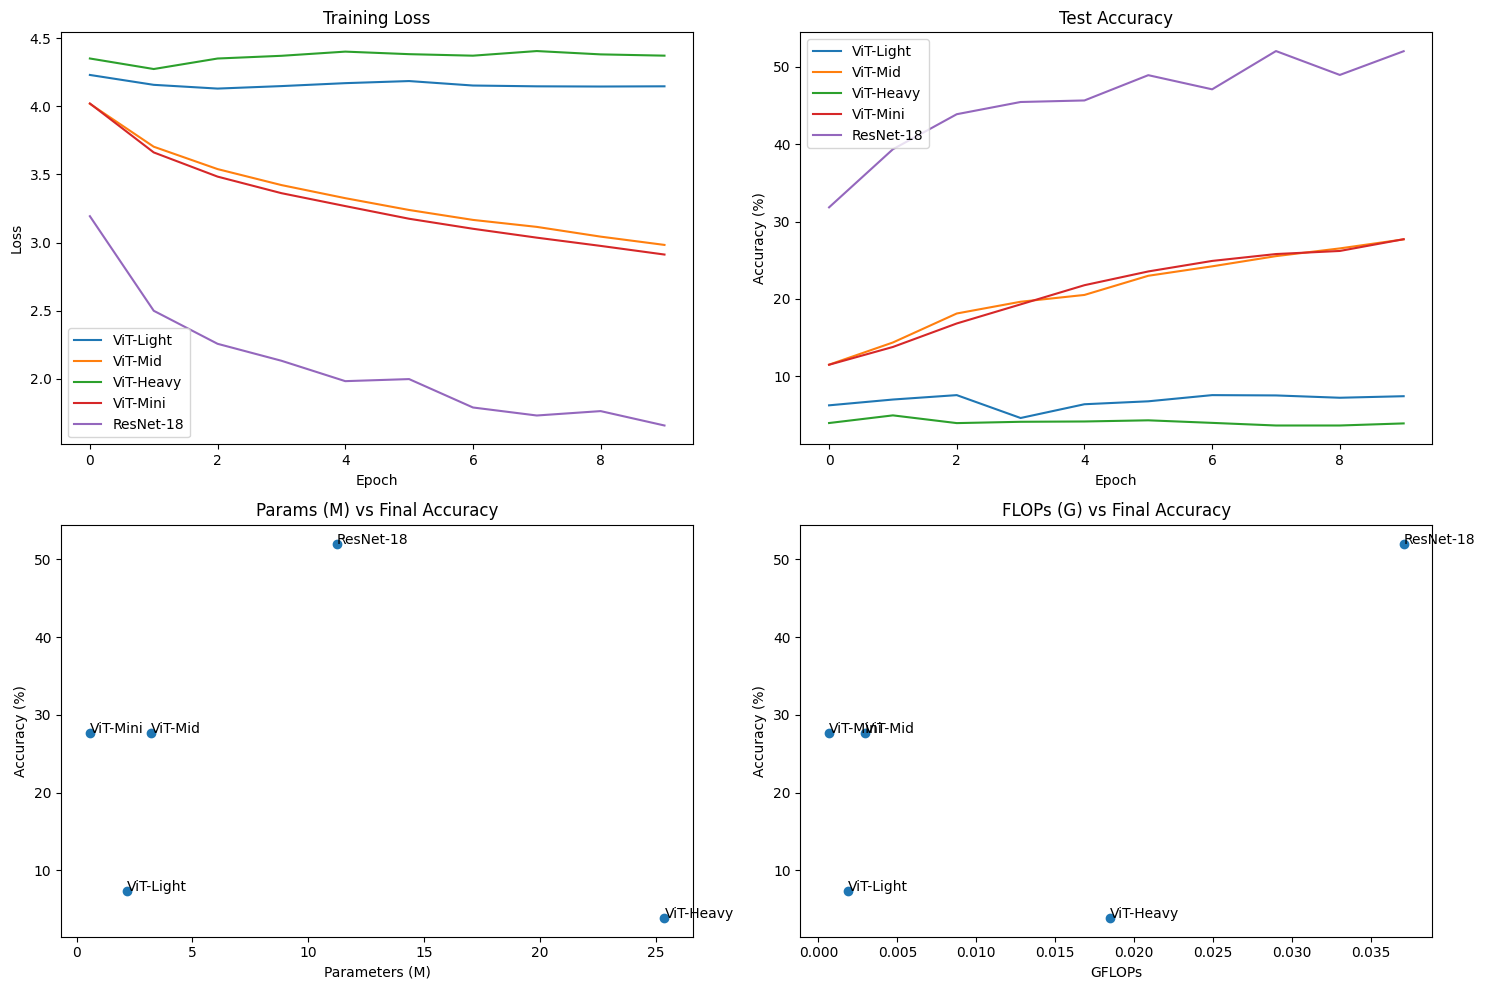

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
import numpy as np
import matplotlib.pyplot as plt
import random

from torchvision.models import resnet18
from torchinfo import summary

# -------------------------------------------------------------------
# (1) SET DEVICE, SEEDS, AND TRANSFORMS
# -------------------------------------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if device == 'cuda':
    torch.cuda.manual_seed_all(seed)


torch.backends.cudnn.benchmark = True

mean = (0.5071, 0.4865, 0.4409)
std  = (0.2673, 0.2564, 0.2762)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# -------------------------------------------------------------------
# (2) CREATE DATASET AND DATALOADERS
# -------------------------------------------------------------------
train_dataset = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform_train
)
test_dataset = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transform_test
)

batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

num_classes = 100

# -------------------------------------------------------------------
# (3) DEFINE THE VISION TRANSFORMER MODULES
# -------------------------------------------------------------------
class PatchEmbedding(nn.Module):
    """
    Splits the input image into patches and projects them to an embedding.
    """
    def __init__(self, image_size=32, patch_size=8, in_channels=3, embed_dim=128):
        super().__init__()
        assert image_size % patch_size == 0, "image_size must be divisible by patch_size"
        self.proj = nn.Conv2d(
            in_channels, embed_dim, kernel_size=patch_size, stride=patch_size
        )
        self.num_patches = (image_size // patch_size) ** 2

    def forward(self, x):
        # x shape: [B, 3, 32, 32]
        x = self.proj(x)      # [B, embed_dim, H', W']
        x = x.flatten(2)      # [B, embed_dim, num_patches]
        x = x.transpose(1, 2) # [B, num_patches, embed_dim]
        return x

class TransformerEncoderBlock(nn.Module):
    """
    A single Transformer encoder block with MHA and Feedforward (MLP).
    """
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # Multi-Head Self-Attention
        x_norm = self.ln1(x)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm)
        x = x + attn_out

        # MLP
        x_norm = self.ln2(x)
        mlp_out = self.mlp(x_norm)
        x = x + mlp_out
        return x

class VisionTransformer(nn.Module):
    """
    Vision Transformer that handles:
      - Patch embedding
      - Learned [CLS] token
      - Positional embeddings
      - Multiple TransformerEncoder blocks
      - Classification head
    """
    def __init__(
        self,
        image_size=32,
        patch_size=8,
        in_channels=3,
        num_classes=100,
        embed_dim=128,
        num_layers=4,
        num_heads=2,
        mlp_dim=256,
        dropout=0.1
    ):
        super().__init__()
        self.patch_embed = PatchEmbedding(image_size, patch_size, in_channels, embed_dim)
        self.num_patches = self.patch_embed.num_patches

        # Add a class token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        # Positional embedding for each patch + 1 for cls token
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))
        self.dropout = nn.Dropout(dropout)

        # Create transformer blocks
        self.blocks = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_dim, dropout)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        # Init
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        B = x.shape[0]

        # Patch + class token + add positional embeddings
        x = self.patch_embed(x)                          # [B, num_patches, embed_dim]
        cls_tokens = self.cls_token.expand(B, -1, -1)    # [B, 1, embed_dim]
        x = torch.cat((cls_tokens, x), dim=1)            # [B, num_patches+1, embed_dim]
        x = x + self.pos_embed[:, : x.shape[1], :]
        x = self.dropout(x)

        # Pass through Transformer blocks
        for block in self.blocks:
            x = block(x)

        # Final norm + classification
        x = self.norm(x)
        cls_out = x[:, 0]  # [CLS] token is first
        logits = self.head(cls_out)
        return logits

# -------------------------------------------------------------------
# (4) TRAINING/TESTING, PARAM/ FLOPs UTILS
# -------------------------------------------------------------------
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

try:
    from torchinfo import summary
    def estimate_flops(model, input_size=(1,3,32,32)):
        # total_mult_adds is # of multiply-add ops, which is roughly 2*FLOPs
        # so we can either keep it as-is or treat half of that as FLOPs.
        # Many references treat "mult-adds" ~ 2 * FLOPs. For consistency,
        # we'll just return model_info.total_mult_adds for comparison.
        model_info = summary(model, input_size=input_size, verbose=0)
        return model_info.total_mult_adds
except ImportError:
    def estimate_flops(model, input_size=(1,3,32,32)):
        print("torchinfo not installed. Returning 0 for FLOPs.")
        return 0

def evaluate_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100.0 * correct / total

def train_model(model, model_name, loader_train, loader_test,
                epochs=10, lr=0.001,
                verbose_every=100):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_accuracies = []
    epoch_times = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        start_time = time.time()

        for i, (images, labels) in enumerate(loader_train):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if (i+1) % verbose_every == 0:
                print(f'[{model_name}] Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(loader_train)}], Loss: {loss.item():.4f}')

        epoch_time = time.time() - start_time
        epoch_times.append(epoch_time)

        # Compute average train loss for logging
        avg_loss = running_loss / len(loader_train)
        train_losses.append(avg_loss)

        # Evaluate test accuracy
        acc = evaluate_accuracy(model, loader_test)
        test_accuracies.append(acc)

        print(f'[{model_name}] Epoch [{epoch+1}/{epochs}] '
              f'Loss: {avg_loss:.4f} | Test Acc: {acc:.2f}% | Time: {epoch_time:.2f}s')

    # Return stats
    return {
        'train_losses': train_losses,
        'test_accuracies': test_accuracies,
        'final_accuracy': test_accuracies[-1],
        'epoch_times': epoch_times,
        'avg_epoch_time': np.mean(epoch_times),
        'parameters': count_parameters(model)
    }

# -------------------------------------------------------------------
# (5) CONFIGURATIONS FOR ViT (4 total) + RESNET BASELINE
# -------------------------------------------------------------------
configs = [
    {
        'name': 'ViT-Light',     # 8x8, 256 embed
        'patch_size': 8,
        'embed_dim': 256,
        'num_layers': 4,
        'num_heads': 2,
        'mlp_dim': 512
    },
    {
        'name': 'ViT-Mid',       # 4x4, 256 embed
        'patch_size': 4,
        'embed_dim': 256,
        'num_layers': 4,
        'num_heads': 4,
        'mlp_dim': 1024
    },
    {
        'name': 'ViT-Heavy',     # 8x8, 512 embed
        'patch_size': 8,
        'embed_dim': 512,
        'num_layers': 8,
        'num_heads': 4,
        'mlp_dim': 2048
    },
    {
        'name': 'ViT-Mini',      # 8x8, 128 embed (extra small custom)
        'patch_size': 8,
        'embed_dim': 128,
        'num_layers': 4,
        'num_heads': 2,
        'mlp_dim': 256
    }
]

# Create ResNet-18 baseline
def create_resnet():
    model = resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# -------------------------------------------------------------------
# (6) EXPERIMENT LOOP
# -------------------------------------------------------------------
def run_experiments():
    results = {}

    EPOCHS = 10  # or 20, depending on your choice
    LR = 0.001

    # Train each ViT config
    for cfg in configs:
        print(f"\n=== Training {cfg['name']} ===")
        vit = VisionTransformer(
            image_size=32,
            patch_size=cfg['patch_size'],
            embed_dim=cfg['embed_dim'],
            num_layers=cfg['num_layers'],
            num_heads=cfg['num_heads'],
            mlp_dim=cfg['mlp_dim'],
            num_classes=num_classes,
            dropout=0.1
        ).to(device)

        flops = estimate_flops(vit, input_size=(1,3,32,32))
        stats = train_model(
            model=vit,
            model_name=cfg['name'],
            loader_train=train_loader,
            loader_test=test_loader,
            epochs=EPOCHS,
            lr=LR
        )
        stats['flops'] = flops
        results[cfg['name']] = stats

    # Train ResNet-18 Baseline
    print("\n=== Training ResNet-18 Baseline ===")
    resnet = create_resnet().to(device)
    resnet_flops = estimate_flops(resnet, input_size=(1,3,32,32))
    resnet_stats = train_model(
        model=resnet,
        model_name="ResNet-18",
        loader_train=train_loader,
        loader_test=test_loader,
        epochs=EPOCHS,
        lr=LR
    )
    resnet_stats['flops'] = resnet_flops
    results["ResNet-18"] = resnet_stats

    return results

# -------------------------------------------------------------------
# (7) RESULTS + PLOTTING
# -------------------------------------------------------------------
def plot_results(all_results):
    """
    Four subplots:
      1. Training Loss vs. Epoch
      2. Test Accuracy vs. Epoch
      3. Parameters vs. Final Accuracy
      4. FLOPs vs. Final Accuracy
    """
    plt.figure(figsize=(15, 10))
    labels = list(all_results.keys())

    # Plot Training Loss
    plt.subplot(2,2,1)
    for model_name, stats in all_results.items():
        plt.plot(stats['train_losses'], label=model_name)
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Test Accuracy
    plt.subplot(2,2,2)
    for model_name, stats in all_results.items():
        plt.plot(stats['test_accuracies'], label=model_name)
    plt.title("Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    # Scatter: Parameters vs Final Accuracy
    plt.subplot(2,2,3)
    x_param = [stats['parameters']/1e6 for stats in all_results.values()]
    y_acc   = [stats['final_accuracy'] for stats in all_results.values()]
    plt.scatter(x_param, y_acc)
    for i, label in enumerate(labels):
        plt.annotate(label, (x_param[i], y_acc[i]))
    plt.title("Params (M) vs Final Accuracy")
    plt.xlabel("Parameters (M)")
    plt.ylabel("Accuracy (%)")

    # Scatter: FLOPs vs Final Accuracy
    plt.subplot(2,2,4)
    x_flops = [stats['flops']/1e9 for stats in all_results.values()]  # GFLOPs
    y_acc   = [stats['final_accuracy'] for stats in all_results.values()]
    plt.scatter(x_flops, y_acc)
    for i, label in enumerate(labels):
        plt.annotate(label, (x_flops[i], y_acc[i]))
    plt.title("FLOPs (G) vs Final Accuracy")
    plt.xlabel("GFLOPs")
    plt.ylabel("Accuracy (%)")

    plt.tight_layout()
    plt.show()

def print_summary_table(all_results):
    """
    Print a table summarizing final results:
      Model | Test Acc | Params (M) | GFLOPs | Time/Epoch (s)
    """
    headers = ["Model", "Test Acc", "Params (M)", "GFLOPs", "Time/Epoch (s)"]
    print("\n===== RESULTS SUMMARY =====")
    print(f"{headers[0]:<15} {headers[1]:<10} {headers[2]:<12} {headers[3]:<10} {headers[4]:<15}")
    print("-"*65)

    for model_name, stats in all_results.items():
        acc = stats['final_accuracy']
        params_m = stats['parameters']/1e6
        gflops = stats['flops']/1e9
        avg_time = stats['avg_epoch_time']
        print(f"{model_name:<15} {acc:<10.2f} {params_m:<12.2f} {gflops:<10.2f} {avg_time:<15.2f}")

# -------------------------------------------------------------------
# (8) RUN EVERYTHING
# -------------------------------------------------------------------
if __name__ == "__main__":
    results = run_experiments()
    print_summary_table(results)
    plot_results(results)



In [ ]:
!pip install torchinfo


In [ ]:
# Install Hugging Face Transformers
!pip install transformers

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
from transformers import SwinForImageClassification, AutoImageProcessor
import numpy as np

# -----------------------
# 1) DEVICE & HYPERPARAMS
# -----------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

num_classes   = 100
batch_size    = 32
learning_rate = 2e-5
num_epochs    = 3   # you can increase up to 5 if you have time

# -------------------------
# 2) IMAGE PROCESSORS + TF
# -------------------------
tiny_proc  = AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
small_proc = AutoImageProcessor.from_pretrained("microsoft/swin-small-patch4-window7-224")

def get_transforms(proc):
    # Swin expects 224×224 inputs
    train_tf = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(proc.image_mean, proc.image_std),
    ])
    test_tf = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(proc.image_mean, proc.image_std),
    ])
    return train_tf, test_tf

def load_datasets(train_tf, test_tf):
    train_ds = torchvision.datasets.CIFAR100(
        root='./data', train=True,  download=True, transform=train_tf
    )
    test_ds  = torchvision.datasets.CIFAR100(
        root='./data', train=False, download=True, transform=test_tf
    )
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, test_loader

# ----------------------------
# 3) MODEL LOADING + FREEZING
# ----------------------------
def load_swin(model_name):
    model = SwinForImageClassification.from_pretrained(model_name)
    # Replace head for CIFAR‑100
    in_feat = model.classifier.in_features
    model.classifier = nn.Linear(in_feat, num_classes)
    # Freeze entire backbone
    for p in model.swin.parameters():
        p.requires_grad = False
    # Only head trains
    num_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params  = sum(p.numel() for p in model.parameters())
    print(f"{model_name}: trainable {num_trainable:,} / total {total_params:,} ({100*num_trainable/total_params:.1f}%)")
    return model.to(device)

# -----------------
# 4) TRAINING LOOP
# -----------------
def train_model(model, name, train_loader, test_loader):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    epoch_times = []
    test_accuracies = []

    for epoch in range(1, num_epochs+1):
        model.train()
        running_loss = 0.0
        t0 = time.time()

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            logits = model(images).logits
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_time = time.time() - t0
        epoch_times.append(epoch_time)

        # evaluate
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                logits = model(images).logits
                preds = logits.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        acc = 100 * correct / total
        test_accuracies.append(acc)

        print(f"[{name}] Epoch {epoch}/{num_epochs} — "
              f"Loss: {running_loss/len(train_loader):.4f}, "
              f"Test Acc: {acc:.2f}%, "
              f"Time: {epoch_time:.1f}s")

    return {
        'final_accuracy': test_accuracies[-1],
        'avg_time_per_epoch': np.mean(epoch_times),
        'trainable_params': sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
    }

# -------------
# 5) EXPERIMENT
# -------------
def experiment():
    results = {}

    # Swin‑Tiny
    print("\n=== Swin‑Tiny Fine‑tuning ===")
    train_tf, test_tf = get_transforms(tiny_proc)
    tl, vl = load_datasets(train_tf, test_tf)
    tiny_model = load_swin("microsoft/swin-tiny-patch4-window7-224")
    stats = train_model(tiny_model, "Swin‑Tiny", tl, vl)
    results["Swin‑Tiny"] = stats

    # Swin‑Small
    print("\n=== Swin‑Small Fine‑tuning ===")
    train_tf, test_tf = get_transforms(small_proc)
    tl, vl = load_datasets(train_tf, test_tf)
    small_model = load_swin("microsoft/swin-small-patch4-window7-224")
    stats = train_model(small_model, "Swin‑Small", tl, vl)
    results["Swin‑Small"] = stats

    return results

# -----------------------
# 6) PRINT SUMMARY TABLE
# -----------------------
def print_summary(results):
    print("\n===== Problem 2 Results =====")
    print(f"{'Model':<15} {'Test Acc (%)':<15} {'Params (M)':<12} {'Time/Epoch (s)':<15}")
    print("-"*60)
    for name, stats in results.items():
        print(f"{name:<15} "
              f"{stats['final_accuracy']:<15.2f} "
              f"{stats['trainable_params']:<12.2f} "
              f"{stats['avg_time_per_epoch']:<15.2f}")

# ----
# RUN
# ----
if __name__ == "__main__":
    res = experiment()
    print_summary(res)


Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]


=== Swin‑Tiny Fine‑tuning ===


100%|██████████| 169M/169M [00:03<00:00, 42.9MB/s]


config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

microsoft/swin-tiny-patch4-window7-224: trainable 76,900 / total 27,596,254 (0.3%)
[Swin‑Tiny] Epoch 1/3 — Loss: 4.2259, Test Acc: 36.87%, Time: 242.8s
[Swin‑Tiny] Epoch 2/3 — Loss: 3.5079, Test Acc: 51.54%, Time: 240.9s
[Swin‑Tiny] Epoch 3/3 — Loss: 2.9967, Test Acc: 56.40%, Time: 240.5s

=== Swin‑Small Fine‑tuning ===


config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/199M [00:00<?, ?B/s]

microsoft/swin-small-patch4-window7-224: trainable 76,900 / total 48,914,158 (0.2%)


model.safetensors:   0%|          | 0.00/199M [00:00<?, ?B/s]

[Swin‑Small] Epoch 1/3 — Loss: 4.1728, Test Acc: 42.72%, Time: 410.9s
[Swin‑Small] Epoch 2/3 — Loss: 3.3699, Test Acc: 56.53%, Time: 410.9s
[Swin‑Small] Epoch 3/3 — Loss: 2.8117, Test Acc: 60.85%, Time: 410.8s

===== Problem 2 Results =====
Model           Test Acc (%)    Params (M)   Time/Epoch (s) 
------------------------------------------------------------
Swin‑Tiny       56.40           0.08         241.41         
Swin‑Small      60.85           0.08         410.84         
